#  Dataset Preparation

In [1]:
import os

# Paths to the dataset
original_dataset_dir = "./raw-img"
base_dir = "./dataset"  # Directory for organized dataset

# Create directories for train, val, test
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

In [3]:
import shutil
from sklearn.model_selection import train_test_split

# Translation dictionary for folder names
translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly",
    "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep",
    "scoiattolo": "squirrel", "dog": "cane", "horse": "cavallo",
    "elephant": "elefante", "butterfly": "farfalla", "chicken": "gallina",
    "cat": "gatto", "cow": "mucca", "spider": "ragno", "squirrel": "scoiattolo"
}


def prepare_dataset():
    if not os.path.exists(base_dir):
        os.mkdir(base_dir)
        os.mkdir(train_dir)
        os.mkdir(val_dir)
        os.mkdir(test_dir)

    # Process each class folder
    for folder in os.listdir(original_dataset_dir):
        folder_path = os.path.join(original_dataset_dir, folder)
        if os.path.isdir(folder_path):
            # Translate folder name
            class_name = translate.get(folder, folder)
            train_class_dir = os.path.join(train_dir, class_name)
            val_class_dir = os.path.join(val_dir, class_name)
            test_class_dir = os.path.join(test_dir, class_name)

            # Create class subfolders
            os.makedirs(train_class_dir, exist_ok=True)
            os.makedirs(val_class_dir, exist_ok=True)
            os.makedirs(test_class_dir, exist_ok=True)

            # Get list of all images
            images = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if img.endswith('.jpeg')]

            # Split into train, val, test
            train, test = train_test_split(images, test_size=0.2, random_state=42)
            train, val = train_test_split(train, test_size=0.125, random_state=42)  # 10% of total for val

            # Copy images to respective folders
            for img in train:
                shutil.copy(img, train_class_dir)
            for img in val:
                shutil.copy(img, val_class_dir)
            for img in test:
                shutil.copy(img, test_class_dir)


prepare_dataset()


# Model Design and Training

In [2]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
import numpy as np
from keras_tuner import Hyperband

## Data Augmentation and Generators

In [3]:
# Constants
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
NUM_CLASSES = 10

# Data Augmentation and Generators
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 16938 images belonging to 10 classes.
Found 2425 images belonging to 10 classes.
Found 4846 images belonging to 10 classes.


## CNN Model Design

In [4]:
def build_model(hp):
    model = models.Sequential([
        layers.Conv2D(hp.Choice('filters_1', [32, 64]), (3, 3), activation='relu', input_shape=(128, 128, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(hp.Choice('dropout_1', [0.2, 0.3])),

        layers.Conv2D(hp.Choice('filters_2', [64, 128]), (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(hp.Choice('dropout_2', [0.3, 0.4])),

        layers.Flatten(),
        layers.Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu'),
        layers.Dropout(hp.Choice('dropout_fc', [0.4, 0.5])),
        layers.Dense(NUM_CLASSES, activation='softmax'),
    ])
    model.compile(
        optimizer=optimizers.Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    directory='tuner_dir',
    project_name='animals10_cnn'
)

tuner.search(train_generator, validation_data=val_generator, epochs=10)
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
model = tuner.hypermodel.build(best_hyperparameters)

Trial 30 Complete [00h 39m 33s]
val_accuracy: 0.20082473754882812

Best val_accuracy So Far: 0.5604123473167419
Total elapsed time: 1d 16h 37m 43s


## Training the Model

In [5]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/20
530/530 [==============================] - 251s 471ms/step - loss: 2.1280 - accuracy: 0.2435 - val_loss: 2.0108 - val_accuracy: 0.2854
Epoch 2/20
530/530 [==============================] - 247s 466ms/step - loss: 1.8685 - accuracy: 0.3429 - val_loss: 1.7067 - val_accuracy: 0.4049
Epoch 3/20
530/530 [==============================] - 243s 457ms/step - loss: 1.7740 - accuracy: 0.3800 - val_loss: 1.5103 - val_accuracy: 0.4816
Epoch 4/20
530/530 [==============================] - 242s 457ms/step - loss: 1.7048 - accuracy: 0.4096 - val_loss: 1.5951 - val_accuracy: 0.4491
Epoch 5/20
530/530 [==============================] - 247s 466ms/step - loss: 1.6400 - accuracy: 0.4321 - val_loss: 1.5026 - val_accuracy: 0.4771
Epoch 6/20
530/530 [==============================] - 254s 478ms/step - loss: 1.5937 - accuracy: 0.4538 - val_loss: 1.4272 - val_accuracy: 0.5105
Epoch 7/20
530/530 [==============================] - 244s 461ms/step - loss: 1.5768 - accuracy: 0.4634 - val_loss: 1.4114 -

## Evaluation

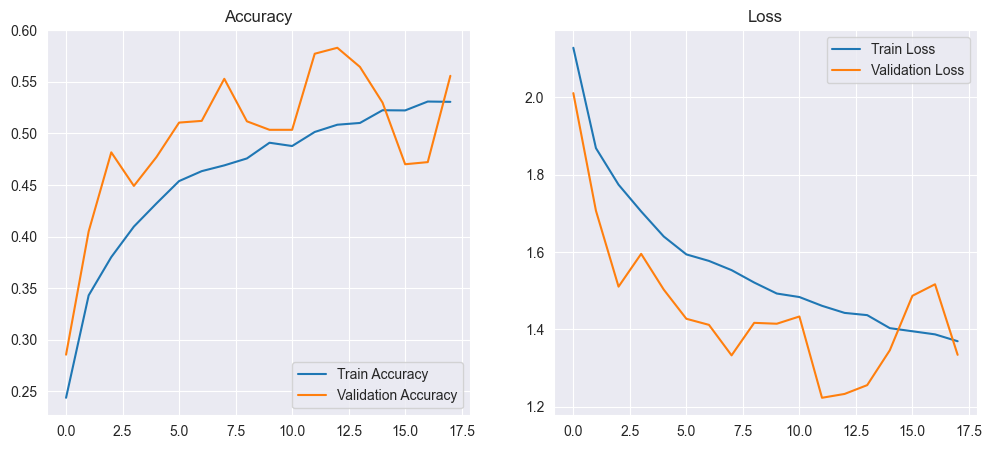

Evaluating on Test Set...
152/152 [==============================] - 21s 137ms/step - loss: 1.2353 - accuracy: 0.5852
Test Loss: 1.2352863550186157
Test Accuracy: 0.5852249264717102
152/152 [==============================] - 11s 70ms/step


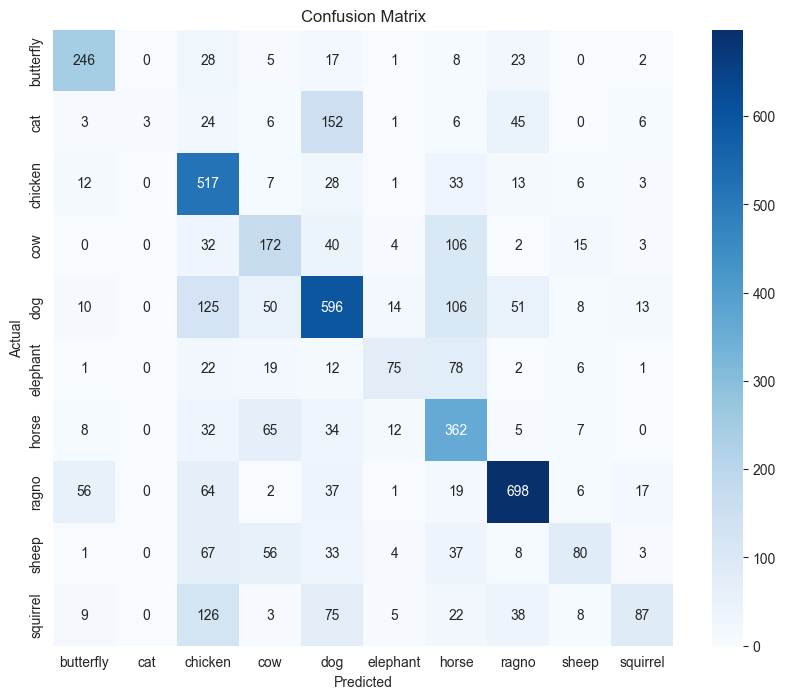

152/152 [==============================] - 11s 71ms/step


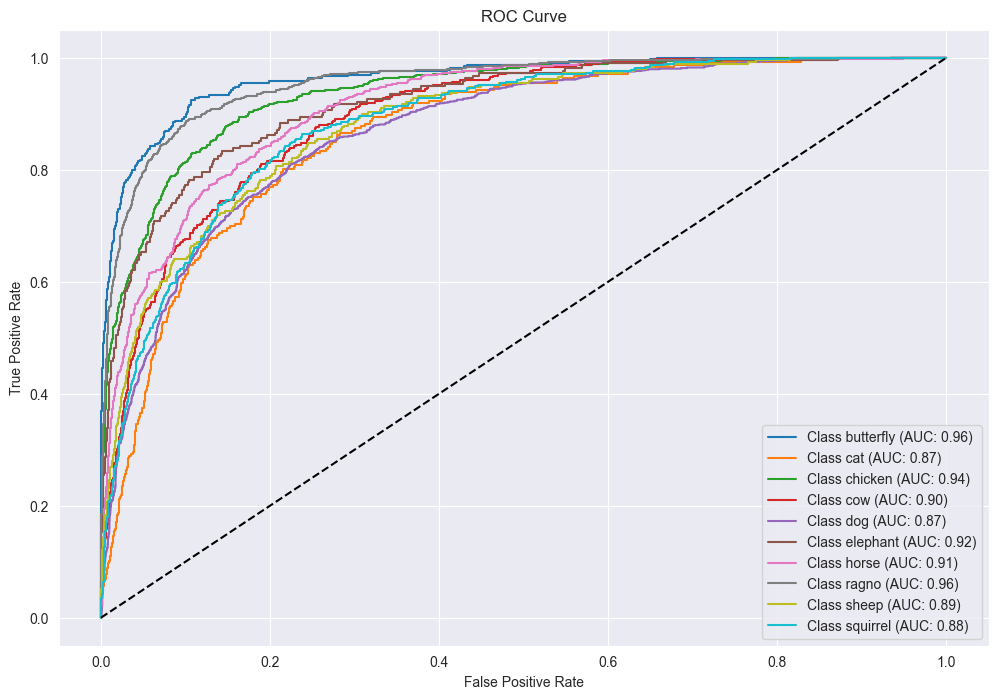

In [6]:
# Plot Learning Curves
def plot_learning_curves(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()


plot_learning_curves(history)

# Evaluation
print("Evaluating on Test Set...")
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Confusion Matrix
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
y_true_binary = label_binarize(y_true, classes=list(range(NUM_CLASSES)))
y_pred_prob = model.predict(test_generator)

plt.figure(figsize=(12, 8))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_true_binary[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {list(test_generator.class_indices.keys())[i]} (AUC: {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

##  Visualize Test Predictions

1/1 [==============================] - 0s 92ms/step


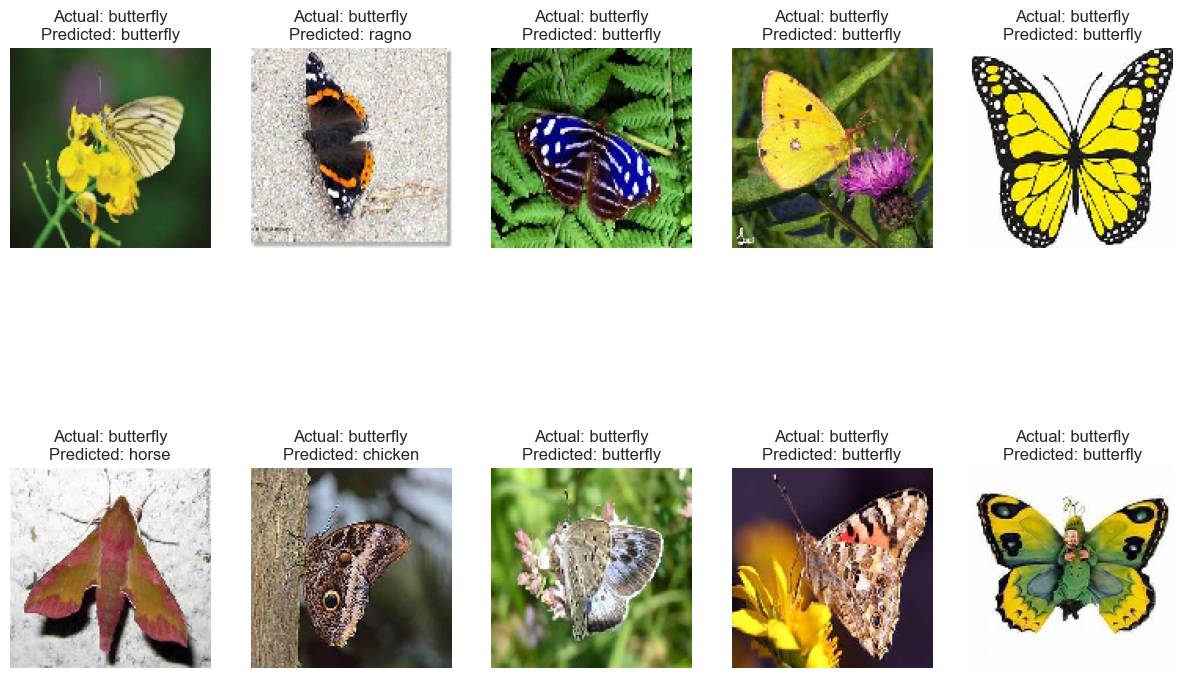

In [12]:
def visualize_predictions(test_generator, model, num_images=10):
    x_test, y_test = next(test_generator)
    y_pred = model.predict(x_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)

    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x_test[i])
        plt.axis('off')
        plt.title(
            f"Actual: {list(test_generator.class_indices.keys())[y_true_labels[i]]}\nPredicted: {list(test_generator.class_indices.keys())[y_pred_labels[i]]}")

    plt.show()


visualize_predictions(test_generator, model)
